<a href="https://colab.research.google.com/github/WenxiGu/text-mining/blob/main/6_NER_master_profesor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets seqeval gradio evaluate
!pip install fsspec==2023.9.2


# Introducción

El r**econocimiento de entidades nombradas (Named-Entity Recognition, NER)** es una técnica esencial en el procesamiento del lenguaje natural que permite identificar y clasificar fragmentos relevantes de texto en categorías predefinidas, como nombres de personas, organizaciones, ubicaciones, fechas… o, en el caso de este ejercicio guiado, **habilidades profesionales (skills)**.

**Por ejemplo**, a partir de un texto como:

> *Buscamos una persona con experiencia en Python, análisis de datos y modelado estadístico.*

Un sistema NER bien entrenado podría detectar y extraer entidades como `Python`,`análisis de datos` y `modelado estadístico`, que son habilidades profesionales de relevancia para desempeñar en una posición laboral como científico de datos.



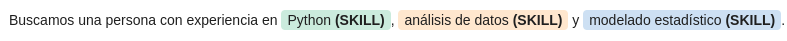


**¿Por qué es útil?**


La extracción automática de este tipo de entidades es muy valiosa para los procesos de selección que llevan a cabo las empresas, ya que permite:

- Comparar de forma automatizada si las habilidades solicitadas en una oferta están presentes en los CVs de los candidatos. Y ordenar y priorizar los candidatos según su grado de adecuación a una posición.

- Extraer información estructurada de descripciones de puestos de trabajo y analizar tendencias del mercado laboral, detectando qué habilidades están siendo más demandadas en cada sector o región.

En este notebook, construiremos un modelo NER adaptado a este tipo de tareas, entrenado sobre textos reales y orientado a su aplicación en entornos profesionales.


En este notebook, construiremos un modelo NER adaptado a este tipo de tareas, entrenado sobre datos reales y orientado a su aplicación en entornos profesionales.


# Proceso Resumido

En este notebook se llevará a cabo el ciclo completo para entrenar un sistema de NER adaptado para la detección de *skills* profesionales.

Para ello, utilizaremos un **modelo de lenguaje** de tipo **encoder**, que ajustaremos para extraer este tipo de entidad del texto. Estos modelos son capaces de representar cada palabra (token) del texto según su contexto, lo que los hace ideales para tareas de extracción de entidades.

El flujo básico será el siguiente:

1. **Tokenización**: Se llevará a cabo la tokenización de los datos de entrenamiento, además de procesados específicos que permitan llevar a cabo el entrenamiento correctamente, como el alineamiento de entidades y subtokens.

2. **Fine-Tuning**:

  a. **Paso por el modelo de lenguaje**:
  A diferencia de tareas como la clasificación de textos, donde se utiliza el token especial `[CLS]` como representación del texto completo, en NER trabajamos con los vectores contextualizados de cada token individual. Esto permite al modelo identificar patrones en secuencias de palabras que indican la presencia de una entidad (como una habilidad).

  b. **Clasificación head**:
  Cada uno de estos vectores es pasado por una capa de clasificación que aprenderá a detectar patrones contextuales para identificar si un token forma parte de una entidad o no.

  👉 Este enfoque convierte el problema en una tarea de **clasificación de tokens**, donde cada token será clasificado individualmente y se le asignará una etiqueta como SKILL o no SKILL, siguiendo un esquema como B-SKILL, I-SKILL, O, etc.

在这个 notebook 里，我们将完成一个面向职业技能（skills）检测的 NER 系统的完整训练流程。

我们会使用一种编码器（encoder）型语言模型并对其进行微调，以从文本中抽取这类实体。此类模型能根据上下文为每个词（token）生成表示，因此非常适合做实体抽取。

基本流程如下：

分词（Tokenization）
对训练数据进行分词，并做一些训练所需的特定处理，例如实体与子词的对齐，以确保训练正确进行。

微调（Fine-Tuning）
a. 经过语言模型：与“文本分类”这类任务不同（文本分类通常用特殊 token [CLS] 代表整段文本），在 NER 中我们使用每个 token 的上下文向量。这样模型就能在词序列中发现指示实体存在的模式（比如一项技能）。
b. 分类头（Classification head）：把这些 token 向量逐个送入一个分类层，学习上下文模式，从而判断该 token 是否属于某个实体。

👉 这种做法把问题转化为逐词分类（token classification）：对每个 token 单独打标签，如 SKILL / 非 SKILL，采用 B-SKILL、I-SKILL、O 等标注方案。

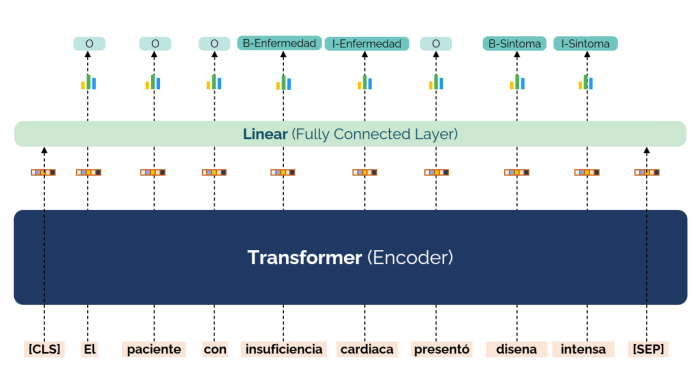

# Descarga y preparación de datos

Para entrenar un modelo NER necesitamos datos etiquetados: textos donde las entidades ya estén marcadas. En este caso, trabajaremos con el [**corpus de SkillSpan**](https://aclanthology.org/2022.naacl-main.366/), un dataset diseñado específicamente para el reconocimiento de skills y conocimientos en descripciones de ofertas de trabajo.

En esta sección descargaremos los datos, los cargaremos como objeto Dataset de Huggingface, y llevaremos algunas preparaciones de datos.

En primer lugar, descargamos los datos de entrenamiento, desarrollo y test del [**repositorio de SkillSpan**](https://github.com/kris927b/SkillSpan):

In [3]:
#Download data
!wget https://github.com/kris927b/SkillSpan/raw/refs/heads/main/data/json/train.json
!wget https://github.com/kris927b/SkillSpan/raw/refs/heads/main/data/json/test.json
!wget https://github.com/kris927b/SkillSpan/raw/refs/heads/main/data/json/dev.json

--2025-11-23 18:13:46--  https://github.com/kris927b/SkillSpan/raw/refs/heads/main/data/json/train.json
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kris927b/SkillSpan/refs/heads/main/data/json/train.json [following]
--2025-11-23 18:13:46--  https://raw.githubusercontent.com/kris927b/SkillSpan/refs/heads/main/data/json/train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2207996 (2.1M) [text/plain]
Saving to: ‘train.json’

train.json          100%[===================>]   2.11M  --.-KB/s    in 0.03s   

2025-11-23 18:13:47 (83.3 MB/s) - ‘train.json’ saved [2207996/2207996]

--2025-11

Estos datos, siguen el formato IOB, y están guardados en un archivo JSON con la siguiente estructura:



```json
{
  "idx": 1,
  "tokens": ["Full", "Stack", "Software", "Engineer", "-", "Java", "/", "JavaScript"],
  "tags_skill": ["O", "O", "O", "O", "O", "O", "O", "O"],
  "tags_knowledge": ["O", "O", "O", "O", "O", "O", "O", "O"],
  "source": "tech"
  }
```

Donde se observa que cada frase ya está tokenizada, y se identifica la presencia de tokens con entidades de tipo skill o conocimiento utilizando el esquema IOB (sólo O en el caso del ejemplo mostrado)



(1) 你的 NER 数据是 IOB/BIO 标注的 JSON，(2) 用 HuggingFace Datasets 的 load_dataset 把它读进来。

tokens：一句话已经切好词/子词的序列。

tags_skill / tags_knowledge：和 tokens 等长的标签序列，采用 IOB/BIO 方案（例子里全是 O，表示“非实体”）。

常见标签：B-SKILL（实体开头）、I-SKILL（实体内部）、O（非实体）。

其它字段（如 idx、source）是元数据。

⚠️ 核心约束：每条样本中 len(tokens) == len(tags_*)。

A continuación, utilizamos la función `load_dataset()` para cargarlos como objetos *Datasets* que puedan funcionar con la librería Transformers del entorno Huggingface.

In [ ]:
from datasets import load_dataset
train_set = load_dataset("json", data_files="train.json", split="train")
dev_set = load_dataset("json", data_files="dev.json", split="train")
test_set = load_dataset("json", data_files="test.json", split="train")

代码里三次 load_dataset("json", data_files=..., split="train") 是分别把 train.json、dev.json、test.json 读成 三个 Dataset 对象（都存在 ["train"] 这个 key 下，所以直接用 split="train" 取出即可）。

Por temas de visualización posteriores, vamos a sustituir las etiquetas `B` e `I` por `B-SKILL` y `I-SKILL`. Para ello definimos una función `convert_tags()` que procese cada elemento del Dataset, buscando en el campo *tags_skill* para llevar a cabo la sustitución:

In [ ]:
def convert_tags(example):
    example["tags_skill"] = [
        "B-SKILL" if tag == "B" else
        "I-SKILL" if tag == "I" else
        "O"
        for tag in example["tags_skill"]
    ]
    return example


train_set = train_set.map(convert_tags)
dev_set = dev_set.map(convert_tags)
test_set = test_set.map(convert_tags)

Indicamos que la columna *tags_skill* es de tipo **ClassLabel** (una variable categórica) con 3 clases: `0`,`B-SKILL` y `I-SKILL`. De esta manera, nos aseguramos que el modelo reciba al entrenar estas etiquetas como índices (0,1 y 2), no como texto; pero posteriormente podamos obtener como predicciones los valores como textos.



这块在把 tags_skill 列显式声明为“序列型的分类标签”，并把 train/dev/test 三个数据集都强制转换（cast）到这个模式，确保后续模型接收的是数值ID而不是字符串。

稳定的 id↔label 对应："O"→0, "B-SKILL"→1, "I-SKILL"→2，训练时用 ID，评估/可视化再映回文字。

In [ ]:
from datasets import Dataset, DatasetDict, ClassLabel, Sequence
ordered_tags = ["O", "B-SKILL", "I-SKILL"]
class_label = ClassLabel(names=ordered_tags)
features = train_set.features.copy()
features["tags_skill"] = Sequence(class_label)

train_set = train_set.cast(features)
dev_set = dev_set.cast(features)
test_set = test_set.cast(features)

Por último generamos un objeto `DatasetDict` para guardar cada partición del corpus:

In [7]:
split_datasets = DatasetDict({
    'train': train_set,
    'test': test_set,
    'validation': dev_set
})

Podemos mirar la estructura del archivo:

In [8]:
split_datasets["train"][0:2]

{'idx': [1, 1],
 'tokens': [['Senior', 'QA', 'Engineer', '(', 'm/f/d', ')', '<ORGANIZATION>'],
  ['<ADDRESS>', '<ADDRESS>', '<ADDRESS>', '<ADDRESS>', '<LOCATION>']],
 'tags_skill': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0]],
 'tags_knowledge': [['O', 'O', 'O', 'O', 'O', 'O', 'O'],
  ['O', 'O', 'O', 'O', 'O']],
 'source': ['tech', 'tech']}

这是在批量取样时看到的标签字段，含义是：

tags_skill 是 逐 token 的标签序列（NER 的 IOB/BIO 标签被编码成数字）。

你取了两条样本，所以是 两个列表：

第1条样本有 7 个 token → [0, 0, 0, 0, 0, 0, 0]

第2条样本有 5 个 token → [0, 0, 0, 0, 0]

这些 0/1/2… 是 ClassLabel 的索引。根据你之前设定的顺序
ordered_tags = ["O", "B-SKILL", "I-SKILL"]，0 就是 "O"（非实体）。

所以这两条样本里，每个 token 的标签都是 “O”（不是技能实体）。

In [9]:
split_datasets

DatasetDict({
    train: Dataset({
        features: ['idx', 'tokens', 'tags_skill', 'tags_knowledge', 'source'],
        num_rows: 4800
    })
    test: Dataset({
        features: ['idx', 'tokens', 'tags_skill', 'tags_knowledge', 'source'],
        num_rows: 3569
    })
    validation: Dataset({
        features: ['idx', 'tokens', 'tags_skill', 'tags_knowledge', 'source'],
        num_rows: 3174
    })
})

Los conjuntos de datos contienen un conjunto de datos de entrenamiento, validación y test. En este caso, el dataset de skillspan contiene 4800 frases de entrenamiento, 3569 frases para validación y 3174 frases de test.


Cada uno de los subsets es de la clase `Dataset`. Se puede acceder a diferentes atributos como *column_names*. Se puede consultar el tipo de cada una de las columnas utilizando el atributo *features*.

In [10]:
print("Columnas del subset de train.")
print(split_datasets["train"].column_names)

print("Tipo de cada columna")
print(split_datasets["train"].features)

Columnas del subset de train.
['idx', 'tokens', 'tags_skill', 'tags_knowledge', 'source']
Tipo de cada columna
{'idx': Value('int64'), 'tokens': List(Value('string')), 'tags_skill': List(ClassLabel(names=['O', 'B-SKILL', 'I-SKILL'])), 'tags_knowledge': List(Value('string')), 'source': Value('string')}


Vamos a ver el tipo de etiquetas que tienen los datos:

In [11]:
tags = split_datasets["train"].features["tags_skill"].feature

In [12]:
tags

ClassLabel(names=['O', 'B-SKILL', 'I-SKILL'])

Si hacemos un print del campo "tags_skill", vemos que cada una de las clases se almacena en formato numérico, siendo cada índice asociado a un nombre de los valores de `ClassLabel`

In [13]:
print(tags)
print(split_datasets["train"][0]["tags_skill"])

ClassLabel(names=['O', 'B-SKILL', 'I-SKILL'])
[0, 0, 0, 0, 0, 0, 0]


Como los valores numéricos no son fácilmente comprensibles, vamos a generar una función llamada `create_tag_names` que cree un campo llamado "ner_tags_str" dentro de cada elemento del dataset.

新增列 ner_tags_str，内容与 tags_skill 一一对应，但变成 'O'/'B-SKILL'/'I-SKILL'。

这是为了人读/调试/画图；训练仍用数字ID。

In [ ]:
def create_tag_names(batch):
  return {"ner_tags_str": [tags.int2str(x) for x in batch["tags_skill"]]}

split_datasets_m = split_datasets.map(create_tag_names)

## Exploración de datos

Ahora comprobamos que los cambios se han aplicado correctamente:

In [15]:
import pandas as pd

In [16]:
fila = 901
pd.DataFrame([split_datasets_m["train"][fila]["tokens"],split_datasets_m["train"][fila]["ner_tags_str"],split_datasets_m["train"][fila]["tags_skill"]], ["tokens","tags","tag_id"]).T

,tokens,tags,tag_id
0,Git,O,0
1,(,O,0
2,GitHub,O,0
3,),O,0
4,Experience,O,0
5,producing,B-SKILL,1
6,cross-browser,I-SKILL,2
7,compatible,I-SKILL,2
8,code,I-SKILL,2


Vamos a comprobar el número de frases con las que contamos en cada partición de datos, aśi como el nuḿero de tokens:

In [17]:
for i in ["train","validation","test"]:
  # Número total de frases
  num_sentences = len(split_datasets[i])

  # Número total de tokens
  num_tokens = sum(len(example["tokens"]) for example in split_datasets[i])

  print(f"Número de frases en {i}: {num_sentences}")
  print(f"Número total de tokens en {i}: {num_tokens}")
  print(f"----------------------------")

Número de frases en train: 4800
Número total de tokens en train: 93453
----------------------------
Número de frases en validation: 3174
Número total de tokens en validation: 40057
----------------------------
Número de frases en test: 3569
Número total de tokens en test: 42786
----------------------------


¿Cuál es la distribución de categorías de tokens en cada partición?

En este punto, vamos a hacer un pequeño preprocesado para ver el número de etiquetas en cada subconjunto de datos:

In [18]:
from collections import Counter, defaultdict

# Creamos diccionario de tipo Counter donde guardaremos resultados del contador
split2freqs = defaultdict(Counter)
# Itera por cada sub split
for split, dataset in split_datasets_m.items():
  # Itera por cada fila del subset split
  for row in dataset["ner_tags_str"]:
    # Para cada lista de etiquetas de cada fila iteramos
    for tag in row:
      if tag.startswith("B"):
        tag_type=tag
        split2freqs[split][tag_type] +=1
      if tag.startswith("I"):
        tag_type=tag
        split2freqs[split][tag_type] +=1
      if tag.startswith("O"):
        tag_type=tag
        split2freqs[split][tag_type] +=1

# Una vez finalizamos mostramos en pantalla
pd.DataFrame.from_dict(split2freqs, orient="index")

,O,B-SKILL,I-SKILL
train,83382,2221,7850
test,38560,1090,3136
validation,35190,1070,3797


Observamos que:

- **Dominancia de la clase `O`**: En los tres conjuntos la mayoría de los tokens están etiquetados como O, lo cual es normal en tareas NER: la mayoría de las palabras no pertenecen a ninguna entidad.

- **Proporción estable entre splits**: Las proporciones de B-SKILL e I-SKILL son bastante similares entre los conjuntos. Esto es bueno porque sugiere que la segmentación se hizo de forma estratificada, manteniendo la misma distribución de clases.

- **Más tokens I-SKILL que B-SKILL**:Esto también es esperable, porque muchas skills son frases con varios tokens ("deep learning", "natural language processing").

# Tokenización de datos


Como se ha visto, los textos ya vienen tokenizados a nivel de palabra en el conjunto de datos descargado. Sin embargo, cuando se usan modelos de lenguaje la tokenización de los términos que los componen se realiza a nivel de subpalabra ("**subword**"), esto introduce un reto: ** ¿cómo etiquetamos correctamente si una palabra se divide en varios subtokens?**

Para ver la tokenización del texto vamos a cargar el objeto AutoTokenizer, que se utilizará para descargar el tokenizador de un modelo de lenguaje pre-entrenado en español. Además, generamos diccionarios de mapeos entre etiquetas e índices de las categorías del corpus:

In [ ]:
from transformers import AutoTokenizer
model_name = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [20]:
indice2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2indice = {tag: idx for idx, tag in enumerate(tags.names)}

### Explicación problema de alineación de etiquetas

En el siguiente ejemplo, las palabras desde "developing" hasta "applications" han sido etiquetadas como una entidad de tipo SKILL, siguiendo el esquema IOB.



In [21]:
text = "Competent with developing multithreaded scalable concurrent applications."
original_tokens = ["Competent", "with", "developing", "multithreaded", "scalable", "concurrent", "applications", "."]
original_labels = ["O", "O", "B", "I", "I", "I", "I", "O"]

Al pasar el texto por un tokenizador:

In [22]:
print(tokenizer.tokenize(text))

['Comp', 'et', 'ent', 'Ġwith', 'Ġdeveloping', 'Ġmult', 'ith', 'read', 'ed', 'Ġscalable', 'Ġconcurrent', 'Ġapplications', '.']


Al pasar las palabras por el tokenizador, observamos que las etiquetas originales están asociadas a palabras completas, pero después de tokenizar cada palabra se puede convertir en varios subtokens. Es decir que necesitamos una función que:

a. Asocie cada subtoken con la etiqueta de su **palabra original**

b. Para los **primeros subtokens**, mantenga la etiqueta original (B, I o O)

c. Para los **subtokens siguientes** se asigna la etiqueta *IGN*. Estos subtokens que con valor "IGN", se les asignará un índice de **-100**, esto evitará que se utilicen esos valores en el calculo de la **loss**, algo importante para no penalizar al modelo en aquellos tokens compuestos por varias subpalabras, ya que si predecimos el primer subtoken el segundo se puede inferir que tiene la misma etiqueta.



子词对齐（word→subword alignment）：原始标签是按“词”打的，但 BERT 这类分词器会把词再切成子词，所以需要把词级标签转换成子词级标签才能训练。

Trabajaremos con el mismo ejemplo de antes. Observamos que las subpalabras de un mismo token tienen el mismo identificador de palabra.

In [23]:
import pandas as pd
# Primero codificaríamos el texto con el tokenizador:
elemento = 38
words, labels = split_datasets_m["test"][elemento]["tokens"], split_datasets_m["test"][elemento]["tags_skill"]

tokenized_input = tokenizer(words,is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids],index=["Tokens", "word ids"])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Tokens,[CLS],*,âĢ¢,Comp,et,ent,with,develop,ing,mult,ith,read,ed,scal,able,concurrent,app,lications,.,[SEP]
word ids,None,0,1,2,2,2,3,4,4,5,5,5,5,6,6,7,8,8,9,None


展示子词对齐用的 word_ids()，确认“同一个原始词被切成多个子词时，这些子词共享同一个 word id”。

Vamos a desarrollar una función que asigne a aquellas subpalabras con el mismo word_ids, una etiqueta "IGN" y un label ids de -100:

In [24]:

# variables auxiliares
previous_word_idx = None
label_ids = []
# Iteramos por cada identificador de subtokens.
for word_idx in word_ids:
  # Si el word_idx es None o igual que el anterior significa que es o bien token s o subword.
  if word_idx is None or word_idx == previous_word_idx:
    # Añadimos un identificador -100 que será ignorado durante la evaluación del modelo
    # (Durante el calculo de la loss)
    label_ids.append(-100)
  # Si el token es distintito, guardamos el identificador numérico de la etiqueta del token
  elif word_idx != previous_word_idx:
    label_ids.append(labels[word_idx])
  previous_word_idx = word_idx
# Generamos una lista sustituyendo los valores numéricos de las etiquetas (label_ids) por sus strings
# Si el valor es -100 lo sustituimos por IGN (ignorar)
labels = [indice2tag[l] if l != -100 else "IGN" for l in label_ids]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=["tokens","word ids","label ids","labels"])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
tokens,[CLS],*,âĢ¢,Comp,et,ent,with,develop,ing,mult,ith,read,ed,scal,able,concurrent,app,lications,.,[SEP]
word ids,None,0,1,2,2,2,3,4,4,5,5,5,5,6,6,7,8,8,9,None
label ids,-100,0,0,0,-100,-100,0,1,-100,2,-100,-100,-100,2,-100,2,2,-100,0,-100
labels,IGN,O,O,O,IGN,IGN,O,B-SKILL,IGN,I-SKILL,IGN,IGN,IGN,I-SKILL,IGN,I-SKILL,I-SKILL,IGN,O,IGN


En esta tabla, cada fila representa una dimensión distinta del procesamiento de texto en tareas de clasificación de tokens.

- La fila de **tokens** contiene los subtokens generados por el tokenizer, ya que una palabra puede dividirse en varios fragmentos.

- La fila de **word ids** indica a qué palabra original pertenece cada subtoken; si aparece como None, significa que ese token es especial (como [CLS] o [SEP]) y no corresponde a ninguna palabra del texto original.

- La fila de **label ids** contiene los valores numéricos utilizados como etiquetas durante el entrenamiento. Un valor de -100 señala que ese token debe ser ignorado en la función de pérdida (loss), esto se aplica a los tokens especiales y a los subtokens que no son el primero de una palabra.  Evita que el modelo se entrene sobre fragmentos parciales de palabra, focalizando la detección del comienzo de éstas para el aprendizaje.

- Finalmente, la fila de **labels** muestra las etiquetas en formato legible, como las del esquema IOB (B-SKILL, I-SKILL y O, consturidos utilizando los lbel_ids



在这张表里，每一行代表了在“逐词分类（token classification）”任务中，文本处理流程的一个维度：


tokens 行：包含分词器生成的子词。因为一个词可能被切分成多个片段。


word ids 行：指明每个子词源自哪一个原始词；如果是 None，表示它是特殊标记（如 [CLS] 或 [SEP]），并不对应原文中的任何词。


label ids 行：是训练时使用的数值标签。-100 表示该位置在损失函数（loss）中应被忽略；这适用于特殊标记以及不是该词第一个子词的那些子词。这样可以避免模型在词的部分片段上学习，把注意力集中在词的开始位置。


labels 行：把 label ids 转换成可读标签（比如 IOB 方案中的 B-SKILL、I-SKILL、O），便于查看与调试。



### Tokenizacion del corpus

Una vez explicado, generamos una función que permita escalar este procesado a todo el corpus. Por una parte generarmos una función que tokenize los datos que se introduzcan de entrada y haga el procesado de las celdas anteriores. Además, generaremos una función para aplicar esa función con un `map()` al corpus.

In [25]:
def tokenize_and_align_labels(examples):
  # Tokenizamos la entrada, ya en tokens (esto es muy importante!).
  tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
  labels = []
  for idx, label in enumerate(examples["tags_skill"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    previous_word_idx=None
    label_ids = []
    for word_idx in word_ids:
        if word_idx is None or word_idx == previous_word_idx:
          label_ids.append(-100)
        else:
          label_ids.append(label[word_idx])
        previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs


Función para procesar cada split:

In [26]:
def encode_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True, remove_columns = ["idx","tags_knowledge","tokens","source","tags_skill"])

Aplicación de las funciones sobre el corpus completo:

In [ ]:
split_datasets_m_encoded = encode_dataset(split_datasets_m)

Después de aplicar la función, vemos que el corpus ya sólo tiene las features requeridas para el entrenamiento.

把原始样本编码成可训练格式，并检查某条样本（test[38]）的对齐后标签向量。

In [28]:
split_datasets_m_encoded["test"][38]["labels"]

[-100,
 0,
 0,
 0,
 -100,
 -100,
 0,
 1,
 -100,
 2,
 -100,
 -100,
 -100,
 2,
 -100,
 2,
 2,
 -100,
 0,
 -100]

split_datasets_m_encoded = encode_dataset(split_datasets_m)
这一步通常会做：tokenizer 子词化 → 生成 input_ids / attention_mask → 词级标签对齐到子词级 → 得到 labels。编码后数据集只保留训练需要的列。

split_datasets_m_encoded["test"][38]["labels"] 打印的这一长串就是子词级标签ID：

-100：忽略位（[CLS] / [SEP] / padding，以及同一词的非首个子词），训练的 loss 不会计算这些位置。

0 / 1 / 2：有效标签的数值ID（按你之前声明的顺序）

0 → "O"

1 → "B-SKILL"

2 → "I-SKILL"

所以你看到的模式如：-100, 0, 0, …, 1, -100, 2, -100, …，表示：

序列开头的 [CLS] → -100

若某个词被切成多个子词：第一个子词拿到 B/I/O 的数字ID，后续子词都是 -100

末尾的 [SEP] / padding 也是 -100

# Fine-Tuning

Una vez que tenemos nuestros datos tokenizados, es hora de crear el modelo, configurar los parámetros de entrenamiento y definir cómo queremos evaluar su rendimiento.


你已经有 input_ids / attention_mask / labels（子词对齐好的，非首子词与特殊符号是 -100）。

用 AutoModelForTokenClassification 把“预训练语言模型的Body”+“一个分类头 Head（线性层）”拼起来，对每个 token输出一个类别分数。

用 Trainer + TrainingArguments 管训练、评估、保存、日志。device 选择 GPU/CPU。

In [29]:
import torch
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Para realizar el ajuste de los modelos se necesitan generar objetos que permitan llevar a cabo esta tarea. Estas clases se pueden desarrollar ad-hoc utilizando la sintaxis de Pytorch o utilizar la librería Transformers, que proporciona clases de Python para facilitar el fine-tuning de estos modelos pre-entrenados.

La idea de estas clases es incorporar un "head" al modelo pre-entrenado que sea capaz de clasificar cada uno de los tokens de entrada al modelo, como se presenta en la figura. En el caso de ajuste de un LM para NER, se necesita cargar una capa de clasificación que tome la representación vectorial de cada token y que permita ajustar los pesos durante el back-propagation.



<center><img src="https://www.oreilly.com/api/v2/epubs/9781098136789/files/assets/nlpt_0404.png" alt="Estructura entrenamiento NER (O'reilly book)" width="150"/></center>




## Definición de métricas de evaluación


Un sistema NER se evalua con métricas similares a un sistema de clasificación de textos: Precision, Recall y $F_1$-score. Para hacer la evaluación de un modelo NER se utilizará la librería recomendada por los autores de la librería Transformers, [seqeval](https://github.com/chakki-works/seqeval). Esta librería toma en su entrada una lista de listas, en la que cada lista interna se compone de un conjunto de etiquetas que se comparan para obtener resultados de rendimiento.

**Lo importante:** una entidad solo se considera correcta si está completamente bien etiquetada (inicio, continuidad y tipo).



In [30]:
from seqeval.metrics import classification_report

true_values = [["O","O","O","B","I","O"],
               ["O","B","O"]]
pred_values  = [["O","O","O","B","O","O"],
               ["O","B","O"]]
print(classification_report(true_values,pred_values))

              precision    recall  f1-score   support

           _       0.50      0.50      0.50         2

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



**De la secuencia 1:**

- Real: ["O", "O", "O", "B", "I", "O"]
- Predicho:["O", "O", "O", "B", "O", "O"]

Aquí, el modelo no reconoció correctamente la entidad "B I". Solo detectó "B", y no la continuó, así que es un error.

**De la secuencia 2:**

- Real: ["O", "B", "O"]
- Predicho:["O", "B", "O"]

Aquí el modelo sí lo hizo bien, reconoció una entidad de un solo token

Lo que se evalua es la **integridad de la entidad completa.**



En ese caso, sólo uno de las dos predicciones ha sido predicho correctamente, así que la precisión y recall será de 0.5.

Dado que las evaluaciones se harán con esa librería, que en su entrada toma una lista de listas, se preparará una función para preparar las predicciones y etiquetas verdaderas de cada muestra en este formato:

In [31]:
import numpy as np

def align_predictions(predictions, label_ids):
  # Obtenemos prediccionnes
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  #  en cada batch de datos
  for batch_idx in range(batch_size):
    # Generamos muestras de true_values y predicciones en formato seq-eval
    example_labels, example_preds = [], []
    # Para cada documento
    for seq_idx in range(seq_len):
      # Ignoramos etiquetas que sean -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(indice2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(indice2tag[preds[batch_idx][seq_idx]])

    labels_list.append(example_labels)
    preds_list.append(example_preds)

  return preds_list, labels_list

Generamos la función **compute_metrics**, que calcule el score obtenido en cada paso de evaluación durante el entrenamiento sobre el conjunto de validación. En este caso generaremos una función que permita evaluar esto a través de la función `align_predictions` creada con anterioridad


In [32]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true,y_pred)}

## Configuración del Entrenamiento del Modelo

Primero generamos los atributos principales de entrenamiento del modelo:

In [33]:
# Cargamos la clase
from transformers import TrainingArguments

# Definimos algunos parámetros de configuracion
num_epochs = 2
batch_size = 8
logging_steps = len(split_datasets_m_encoded["train"]) // batch_size
model_name_save = f"output-model"

Posteriormente generamos la clase de argumenos de entrenamiento que utilizaremos posteriormente. Esta clase requiere introducir parámetros de configuración de entrenamiento a modelo a través de la clase `TrainingArguments`. Utilizando esta clase se le proporciona información como el número de epocas de entrenamiento, el batch_size, la estrategia de evaluación...


In [34]:
import random
import numpy as np
import torch

def set_seed(seed=52):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(52)

In [35]:
training_args = TrainingArguments(
    output_dir = model_name_save, log_level = "error",
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    save_steps=50,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=50,
    gradient_accumulation_steps=2,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    logging_strategy="steps",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    seed=52,
    full_determinism=True
)

## Entrenamiento del modelo

Una vez generadas todas las funciones necesarias para el entrenamiento, vamos a hacer el ajuste del modelo. Para ello vamos a beneficiarnos de clase [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer).



In [ ]:
from transformers import AutoConfig
model_config = AutoConfig.from_pretrained(model_name,
                                            num_labels = tags.num_classes,
                                            id2label = indice2tag,
                                            label2id = tag2indice)

上半段把任务标签信息写进模型配置；下半段的 data_collator 负责在送入模型前，对输入与标签做批内动态填充，保证维度对齐并正确忽略 padding 的损失。

- **`data_collator`**: Esta función lo que hará es ajustar las secuencias de entrada para que tengan todas la misma longitud. Este padding también se hace sobre las etiquetas que van a ser predichas. Para ello utilizamos las clases existentes en la librería transformers.

Todos las entradas en un batch deben tener la misma longitud en tokens Para ellos: Detectar la longitud más larga del batch y aplicar el padding dinámicamente a los ejemplos más cortos para que todos tengan la misma longitud

- Ejemplo 1: [CLS] I am happy [SEP]  (5 tokens)

- Ejemplo 2: [CLS] You are amazing today [SEP] (6 tokens)


Al introducirlos al modelo, se rellenan con tokens especiales de padding, para que la longitud sea la misma.

- [CLS] I     am     happy   [SEP] [PAD]  (6 tokens)
- [CLS] You   are    amazing today [SEP]  (6 tokens)


In [37]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer,return_tensors="pt")

- **`model_init`**: Función que permite pre-cargar el modelo que va a ser ajustado.


In [ ]:
from transformers import AutoModelForTokenClassification
def model_init():
    return AutoModelForTokenClassification.from_pretrained(
    model_name, config=model_config
)
model = AutoModelForTokenClassification.from_pretrained(model_name, config=model_config)



In [39]:
from transformers import Trainer
trainer = Trainer( model=model,
                  args = training_args,
                  data_collator = data_collator,
                  compute_metrics = compute_metrics,
                  train_dataset = split_datasets_m_encoded["train"],
                  eval_dataset = split_datasets_m_encoded["validation"],
                  tokenizer = tokenizer)

/tmp/ipython-input-3048332595.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer( model=model,


Una vez creado el objeto es tan sencillo como entrenar utilizando el método `.train()`:

In [40]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
W1123 18:15:50.948000 496 torch/_inductor/utils.py:1558] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Step,Training Loss,Validation Loss,F1
50,0.409700,0.288518,0.000000
100,0.290600,0.234161,0.172662
150,0.199300,0.333054,0.114438
200,0.198100,0.182156,0.278917
250,0.182700,0.160832,0.318219
300,0.146500,0.164140,0.318855
350,0.096000,0.166353,0.397391
400,0.083000,0.174728,0.390499
450,0.108800,0.170967,0.418759
500,0.106700,0.157943,0.386111


TrainOutput(global_step=600, training_loss=0.16685407559076945, metrics={'train_runtime': 710.551, 'train_samples_per_second': 13.511, 'train_steps_per_second': 0.844, 'total_flos': 599812508051424.0, 'train_loss': 0.16685407559076945, 'epoch': 2.0})

A continaución analizemos las cúrvas de pérdida:

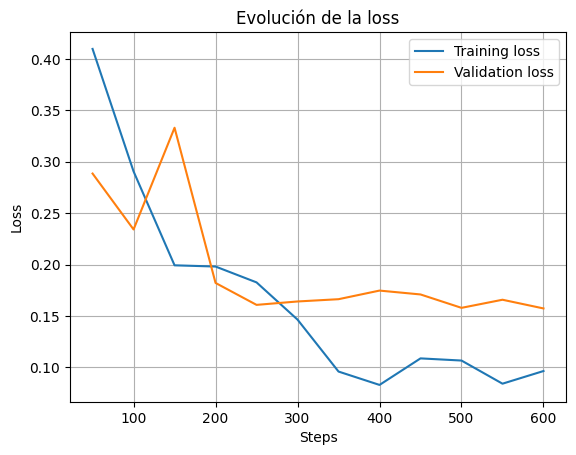

In [41]:
# Mostrar curva de pérdida usando los logs del trainer
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(trainer.state.log_history)
# Separar las filas de entrenamiento y evaluación
train_rows = df[df["loss"].notna()].copy()
eval_rows = df[df["eval_loss"].notna()].copy()

# Fusionar por columna 'step'
combined = pd.merge(train_rows, eval_rows, on="step", suffixes=("_train", "_eval"))


# Filtramos solo los pasos con loss y eval_loss
loss_log = combined[["step", "loss_train", "eval_loss_eval"]].dropna()

plt.plot(loss_log["step"], loss_log["loss_train"], label="Training loss")
plt.plot(loss_log["step"], loss_log["eval_loss_eval"], label="Validation loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Evolución de la loss")
plt.legend()
plt.grid()
plt.show()

La gráfica muestra una evolución típica del entrenamiento de un modelo, donde el loss de entrenamiento disminuye de forma constante, mientras que el loss de validación baja inicialmente pero luego se estabiliza con pequeñas oscilaciones. Esto indica que el modelo aprende bien al principio, pero a partir de cierto punto (alrededor del paso 300) comienza a mostrar signos de sobreajuste, ya que mejora en los datos de entrenamiento pero no en los de validación. Sería recomendable aplicar estrategias como early stopping o regularización para evitar que el modelo pierda capacidad de generalización.

Si se había habilitado la opción de `push_to_hub=True` en el objeto  `TrainingArguments`, se puede hacer un push del modelo a HuggingFace Hub.

In [42]:
trainer.push_to_hub(commit_message="Training completed!")

HfHubHTTPError: 401 Client Error: Unauthorized for url: https://huggingface.co/api/repos/create (Request ID: Root=1-692351fb-14bc6ef64c88226e7a3ee205;64129b91-70b2-4137-b52d-9c4fe5f648a5)

Invalid username or password.

Si se quisiera, el modelo también se podría guardar en un directorio local para utilizarlo con posterioridad. Para ello se puede utilizar el método `.save_model()`, que permite guardar los archivos del modelo ajustado en un directorio local:

In [43]:
trainer.save_model("model_ner_master")

## Evaluación del modelo

Una vez entrenado el modelo de reconocimiento de entidades y visto su funcionamiento en una frase específica, ya podríamos evaluar el rendimiento del modelo sobre el conjuntos de datos de test:

In [ ]:
# Descargo y vuelvo a cargar el modelo anterior para llevar a cabo la evaluacíon.
model_id = "luisgasco/model_ner_master"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForTokenClassification.from_pretrained(model_id)
trainer = Trainer(
    model=model,
    args = training_args,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    train_dataset = split_datasets_m_encoded["train"],
    eval_dataset = split_datasets_m_encoded["validation"],
    tokenizer = tokenizer
)

Para ello, en primer lugar utilizamos el modelo para predecir los datos sobre el conjunto de test.

In [45]:
predictions_test = trainer.predict(split_datasets_m_encoded["test"])

En esta ocasión, para calcular las métricas de rendimiento sobre el conjunto de datos de test, vamos a descargar unas métricas predefinidas en la liberíra Datasets, especificamente utilizando la clase [`load_metrics()`](https://huggingface.co/docs/datasets/v2.7.1/en/loading#metrics).

Con ese método se descargarán los métodos de evaluación presentes en seqeval, y podremos utilizar el objeto para obtener los resultados de evaluación:

用 seqeval 评估 NER 的预测
seqeval 按“实体序列”计算 precision / recall / F1（支持 IOB/BIO）。


In [ ]:
import evaluate
metric = evaluate.load("seqeval")

# Obtenemos las predicciones y las etiquetas por cada lado
predictions, labels = predictions_test.predictions,predictions_test.label_ids
predictions = np.argmax(predictions, axis=2)

# Obtenemos las predicciones verdaderas y las predichas y las guardamos en una lista
true_predictions = [
        [indice2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
true_labels = [
    [indice2tag[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
# OBtenemos los resultados de la evaluación a través del método compute.
results = metric.compute(predictions=true_predictions, references=true_labels)

In [47]:
results

{'SKILL': {'precision': np.float64(0.3788546255506608),
  'recall': np.float64(0.39413382218148485),
  'f1': np.float64(0.3863432165318958),
  'number': np.int64(1091)},
 'overall_precision': np.float64(0.3788546255506608),
 'overall_recall': np.float64(0.39413382218148485),
 'overall_f1': np.float64(0.3863432165318958),
 'overall_accuracy': 0.9423175805169915}

## Análisis de error <a name="id3_5_4"></a>

Una vez y entrenado el modelo siempre surge una pregunta de forma recurrente: **¿cómo podríamos mejorarlo?**

Para llevar a cabo un proceso de mejora de un modelo de inteligencia artificial es necesario llevar a cabo un **análisis exhaustivo de errores de predicción** en el conjunto de datos de validación y/o test. Esto permitirá identificar problemas en las predicciones que nos ayuden a:

- Detectar fallos de anotación recurrentes que permitan corregir los datos o refinar las guías de anotación si fuera necesario.
- Identificar fallos de predicción del sistema provocados por falta de datos.
- Identificar posibles post-procesados que permitan mejorar el rendimiento del sistema sin un re-entrenamiento.

Además, si el modelo funciona mucho peor de los esperado, analizar los errores puede ayudarnos a identificar problemas de preprocesado de datos, de evaluación de resultados o cualquier otro tipo de *bug* en nuestro código.


##### Preparación datos

Para llevar a cabo el análisis de error, vamos a generar una función que permita procesar los datos de validación o de test y que nos permita obtener el *loss* y las etiquetas predichas para cada token. El *loss* es una métrica que representa si un token es correcto o incorrecto, a un valor mayor el token tendrá una probabilidad mayor de ser incorrecto.

In [48]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convertimos los datos en una lista de diccionarios para que puedan ser procesados por el
    # data collator.
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Padding de las entradas y etiquetas para obtener las predicciones.
    new_batch = data_collator(features)
    input_ids = new_batch["input_ids"].to(device)
    attention_mask = new_batch["attention_mask"].to(device)
    labels = new_batch["labels"].to(device)
    with torch.no_grad():
        # Pasa los datos a través del modelo
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predecimos la clase más probable como aquella que tenga el logit más alto.
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculamos la loss por token. La los en NER está siendo cross_entroy
    loss = cross_entropy(output.logits.view(-1, tags.num_classes),
                         labels.view(-1), reduction="none")
    # Hacemos el unflatten para ponerlo en formato de salida
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}


El dataset de validación procesado anteriormente tiene un campo `ner_tags_str` que habría que eliminar para que no hubiera error al aplicar la función anterior.

In [ ]:
#Eliminamos campos innecesarios
valid_set = split_datasets_m_encoded["validation"]
valid_set = valid_set.map(batched=True, batch_size=32,
                      remove_columns=['ner_tags_str'])
# Aplicamos la función anterior y la transformamos en un pandas dataframe.
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
valid_df = valid_set.to_pandas()

In [50]:
valid_df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label
0,"[50281, 11148, 47901, 19217, 254, 9, 7142, 371...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, 0, -100, 0, 0, 0, 0, 0, -100, ...","[0.0, 0.00054499554, 0.0, 0.0001295721, 0.0, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Si observamos el dataframe, se ve que en la columna *labels*, *input_ids* y *predicted_label* contiene valores numéricos, lo que puede provocar problemas durante el análisis de los resultados por dificultad en su interpretabilidad. A continuación vamos a transformar esos valores numéricos por strings.

In [51]:
# Creamos el indice -100 en el diccionario indice2tag
indice2tag[-100] = "IGN"
# Convertimos los identificadores de token en su forma string
valid_df["input_tokens"] = valid_df["input_ids"].apply(lambda x: tokenizer.convert_ids_to_tokens(x))
# Sustituimos las etiquetas predichas por la etiqueta en string
valid_df["predicted_label"] = valid_df["predicted_label"].apply(lambda x: [indice2tag[i] for i in x])
valid_df["labels"] = valid_df["labels"].apply(lambda x: [indice2tag[i] for i in x])
valid_df['loss'] = valid_df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
valid_df['predicted_label'] = valid_df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
valid_df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[50281, 11148, 47901, 19217, 254, 9, 7142, 371...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, O, IGN, O, O, O, O, O, IGN, O, I...","[0.0, 0.00054499554, 0.0, 0.0001295721, 0.0, 7...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[[CLS], Dev, Ops, Engine, er, (, CI, CD, Cloud..."


Además, de cara a hacer análisis a nivel de subword, a partir del dataframe anterior vamos a generar un dataframe en el que cada fila sea una subpalabra, con sus atributos asociados como columnas (incluyendo su ´loss´ y su ´predicted_label´

In [52]:
df_tokens = valid_df.apply(pd.Series.explode)
# Vamos a ignorar los token IGN.
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(3)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,11148,1,O,0.0,O,Dev
0,19217,1,O,0.0,O,Engine
0,9,1,O,0.0,O,(


Una vez tengamos los datos preparados, podemos empezar a hacer algunos análisis de error.



##### Losses per token

En primer lugar, mostraremos un análisis de error típico, que es analizar el valor agregado de la *loss* para cada token del conjunto de datos. Esto permite identificar si hay errores de predicción altos tanto en tokens frecuentes (con el valor medio) como poco frecuentes ( con la suma y el conteo de ocurrencias del token).

Para realizar este análisis vamos a calcular el número de veces que aparece cada token en los datos, así como la suma total de su *loss* y el valor medio.

In [53]:
df_tokens_loss_token = df_tokens.groupby("input_tokens")[["loss"]].agg(["count", "mean", "sum"]).droplevel(level=0, axis=1)# Elimnamos columnas con más de un nivel

###### Tokens con loss total más alta

Por ejemplo, podríamos mostrar los tokens que tengan un valor total de *loss* más alto:

In [54]:
(
    df_tokens_loss_token
    .sort_values(by=["sum"], ascending=False)
    .reset_index()
    .round(2)
    .head(20)
)

,input_tokens,count,mean,sum
0,and,1823,0.21,385.34
1,the,1175,0.18,208.11
2,of,916,0.22,198.86
3,to,976,0.19,185.37
4,in,749,0.22,163.83
5,a,686,0.21,143.33
6,with,477,0.29,136.86
7,for,454,0.25,115.01
8,our,291,0.26,76.74
9,development,144,0.53,76.67


Observando esa tabla se pueden llegar a algunas conclusiones:

1. **Tokens funcionales comunes**
Tokens como `and`, `the`, `of`, `to`, `in`, `a`, `on`, `be`:
  - Son muy frecuentes.
  - Tienen un **loss promedio moderado** (entre 0.15 y 0.22).
  - Aunque no son individualmente problemáticos, su **alta frecuencia los hace acumular mucho loss total**.
  - Posible causa: el modelo puede tener dificultades para identificar correctamente los límites de las entidades cuando están cerca de estas palabras.

2. **Preposiciones y conectores relevantes**
Tokens como `with`, `for`, `our`:
  - Tienen **loss promedio más alto** (entre 0.25 y 0.29).
  - Estos tokens suelen estar cerca de entidades, y pueden introducir **ambigüedad contextual**.
  - El modelo puede tener dudas sobre si lo que sigue debe ser etiquetado como entidad.

3. **Tokens de contenido informativo**
Tokens como `development`, `work`, `develop`, `data`, `team`, `management`, `business`:
  - Tienen un **loss promedio elevado** (de 0.32 hasta 0.82).
  - Aunque aparecen menos, su impacto por token es alto.
  - Suelen formar parte de **entidades compuestas o polisémicas** (ej.: "business development").
  - Posible causa: el modelo falla en **reconocer los límites de la entidad o aplicar la etiqueta correcta**.



###### Tokens con avg loss

Vamos a ordenar los datos por avg loss más alto, pero filtrando el número de veces que haya aparecido el token como mínimo, ya que esto evitará mostrar errores poco frecuentes.

In [55]:
filtrado = df_tokens_loss_token.sort_values(by=["mean"], ascending=False).reset_index().round(2)
min_freq = 20
filtrado.loc[filtrado["count"]>min_freq].head(15)

,input_tokens,count,mean,sum
129,analysis,36,1.24,44.75
216,commun,21,0.86,18.15
231,management,61,0.82,49.90
235,data,70,0.81,56.45
252,appro,32,0.74,23.76
273,building,32,0.69,22.23
277,external,24,0.69,16.58
284,customer,33,0.68,22.59
285,get,21,0.68,14.34
286,Âķ,42,0.68,28.66


##### Losses per label

En segundo lugar, mostraremos las etiquetas con un  *loss*  más alto. En el caso de este notebook, en el que hemos entrenado un sistema NER que sólo tiene que predecir una etiqueta, no aporta mucha información, pero nos puede ayudar a identificar la magnitud de problemas a la hora de predecir entidades de más de un token analizando la etiqueta "I-ETIQUETA".


Para realizar este análisis vamos a calcular el número de veces que aparece cada etiqueta en los datos, calculando la suma total de su *loss* y el valor medio.

In [56]:
df_tokens_loss_label = df_tokens.groupby("labels")[["loss"]].agg(["count", "mean", "sum"]).droplevel(level=0, axis=1)# Elimnamos columnas con más de un nivel

In [57]:

(
    df_tokens_loss_label
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)


,0,1,2
labels,B-SKILL,I-SKILL,O
count,1070,3797,35190
mean,1.21,1.1,0.06
sum,1298.38,4166.9,2217.86


La loss más grande es la relaccionada con la etiqueta I-SKILL, lo que podría significar que el modelo identifica bien lso comienzos de entidades pero tiene problemas para detectar las entidades completas.

##### Matriz de confusión

También se puede generar una matriz de confusión pque permita evaluar cuantas veces se equivocó a la hora de asignar las etiqetas en los tokens y ver con que clase fueron clasificadas por el modelo.

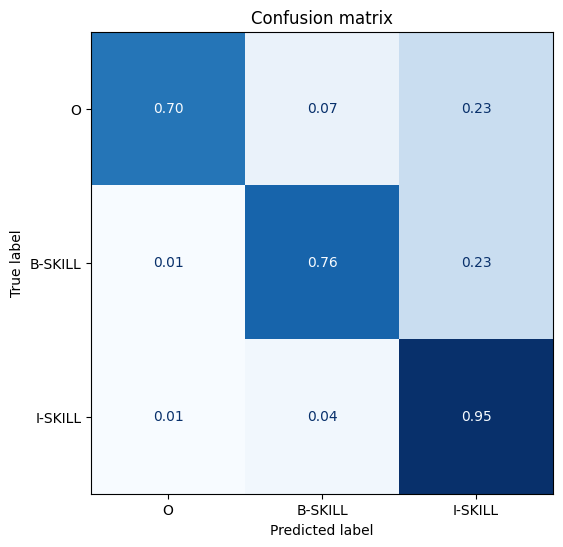

In [58]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels, normalizado = "true"):
    cm = confusion_matrix(y_true, y_preds, normalize=normalizado)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Confusion matrix")
    plt.show()


plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names,normalizado="true")

Por ejemplo, en la matriz de confusión se observa que hay un 23% de etiquetas de tipo B-SKILL, que representan el inicio de una entidad,  que es clasificada como I-SKILL.

En el caso de la categoría O, se clasifica correctamente en un 70%, pero hay un 23% de falsos positivos como I-SKILL, lo cual sugiere que el modelo está detectando entidades donde no las hay.

Se podría buscar en que elementos está ocurriendo este comportamiento para intentar inferir el motivo de esta actuación.

In [59]:
df_tokens[(df_tokens.labels=="B-SKILL") &  (df_tokens.predicted_label =="I-SKILL")]

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
21,1811,1,B-SKILL,0.83,I-SKILL,roll
29,11713,1,B-SKILL,2.05,I-SKILL,commun
43,26460,1,B-SKILL,0.94,I-SKILL,lead
43,484,1,B-SKILL,1.82,I-SKILL,up
135,45552,1,B-SKILL,3.71,I-SKILL,deploy
187,54,1,B-SKILL,3.89,I-SKILL,U
383,22035,1,B-SKILL,1.14,I-SKILL,team
430,1601,1,B-SKILL,3.24,I-SKILL,work
495,42959,1,B-SKILL,0.96,I-SKILL,attention
495,11145,1,B-SKILL,1.62,I-SKILL,make


##### Secuencias con más losses



De cara a trabajar a nivel de frase, también se podrían recuperar las frases que tienen una ´loss´ mayor, que son aquellas que el modelo ha tenido más dificultad para extraer entidades con seguridad.

Para calculamos el loss total para cada frase como la suma de las loss de cada unos de los tokens que la componen y generamos el campo ´text´ para mostrar resultados fácilmente:

In [60]:
# Calculamos la loss total.
valid_df["total_loss"] = valid_df["loss"].apply(sum)

# Generamos el texto
def reconstruct_text_from_input_ids(input_ids, labels, tokenizer):
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    words = []
    current_word = ""
    for i, (token, label) in enumerate(zip(tokens, labels)):
        if token in ["[CLS]", "[SEP]"]:
            continue  # ignoramos tokens especiales

        # BERT-style: ## indica subtoken
        if token.startswith("##"):
            current_word += token[2:]

        # RoBERTa-style: Ġ indica inicio de palabra
        elif token.startswith("Ġ"):
            if current_word:
                words.append(current_word)
            current_word = token[1:]

        # Token sin prefijos: nuevo token
        else:
            if current_word:
                words.append(current_word)
            current_word = token

    if current_word:
        words.append(current_word)

    return " ".join(words)


valid_df["text"] = valid_df.apply(
    lambda row: reconstruct_text_from_input_ids(row["input_ids"], row["labels"], tokenizer),
    axis=1
)# Cojemos el top-10 y los mostramos en pantalla:

Vamos a coger el top-10 de frases peor predichas:

In [61]:
df_10worst = valid_df.sort_values(by="total_loss", ascending=False)[0:10]

Mostramos en pantalla esas frases.

In [62]:
import gradio as gr
from transformers import pipeline
import spacy
from spacy.tokens import Doc, Span
from spacy import displacy

ner_pipeline  = pipeline("token-classification", model="luisgasco/model_ner_master", aggregation_strategy = "simple")
# Carga vocabulario vacío
nlp = spacy.blank("en")

def render_entities(text):
    # Obtener predicciones del modelo
    preds = ner_pipeline(text)

    ents = []
    for ent in preds:
        ents.append({
            "start": int(ent["start"]),
            "end": int(ent["end"]),
            "label": str(ent["entity_group"])
        })

    # Estructura para displacy (modo manual)
    ex = {
        "text": text,
        "ents": ents,
        "title": None
    }

    # Renderizar con displaCy sin usar spaCy Doc
    html = displacy.render(ex, style="ent", manual=True, jupyter=True)

    return f"<div style='padding:1em;font-size:1.1em'>{html}</div>"
for texto, loss in zip(df_10worst.text.to_list(), df_10worst.total_loss.to_list()):
  print("Frase con loss {}:".format(loss))
  render_entities(texto)

Frase con loss 93.1549072265625:


Frase con loss 92.1207275390625:


Frase con loss 77.29084014892578:


Frase con loss 64.9297866821289:


Frase con loss 64.6836166381836:


Frase con loss 62.17837142944336:


Frase con loss 60.93889236450195:


Frase con loss 60.5145263671875:


Frase con loss 59.62661361694336:


Frase con loss 58.2069091796875:


###### Representacion más visual

Es muy difícil analizar, por ese motivo vamos a generar una función para visualizar los resultados de forma más atractiva y ver como se han detectado las entidades las frases.

In [63]:
import spacy
from spacy import displacy
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

ner_map = {'0': '0',
           'B-SKILL': 'B-SKILL',
           'I-SKILL': 'I-SKILL'}

options = {"ents": ["SKILL"],
           "colors": {"SKILL": "lightblue"}}

tokenizer = AutoTokenizer.from_pretrained("luisgasco/model_ner_master")
model = AutoModelForTokenClassification.from_pretrained("luisgasco/model_ner_master")
ner_pipeline = pipeline(task='ner', model=model, tokenizer = tokenizer)
nlp = spacy.blank("es")

def apply_ner(text: str):
    classifications = ner_pipeline(text)

    entities = []
    for i in range(len(classifications)):
        if classifications[i]['entity'] != 0:
            if ner_map[classifications[i]['entity']][0] == 'B':
                j = i + 1
                while j < len(classifications) and ner_map[classifications[j]['entity']][0] == 'I':
                    j += 1
                entities.append((ner_map[classifications[i]['entity']].split('-')[1], classifications[i]['start'],
                                 classifications[j - 1]['end']))
    doc = nlp(text)

    ents = []
    for ee in entities:
        ents.append(doc.char_span(ee[1], ee[2], ee[0]))
    doc.ents = ents

    displacy_html = displacy.render(doc, style="ent", options=options,jupyter=True)
    return displacy_html

Utilizando la función anterior e iterando, podemos visualizar los resultados de forma más visual, identificando que algunos de los errores pueden ser debidos a spans muy largos, falsos positivos o otro tipo de causas.

> Hay espacios de más entre términos porque no ha gestionado la unión de las subwords.

In [64]:
from IPython.core.display import display, HTML

for texto, loss in zip(df_10worst.text.to_list(), df_10worst.total_loss.to_list()):
  display(HTML('<hr class="rounded">'))
  display(HTML('<a> Frase con loss {} </a>'.format(loss)))
  print(texto)
  render_entities(texto)

This post doc position will research software arch itect ures for mobile ub iquit ous and wear able comput ing and will Âķ make a technical review of phys iological sensors ( EE G Heart rate G SR ) to be used for the Âĳ in - the - wild ÂĴ platform Âķ particip ate in the design of exper iments and data analysis appro ach Âķ analy se data from two Âĳ in - the - wild ÂĴ exper iments with special emphasis on handling missing / no isy data and multi - modal integration Âķ fac ilit ate technology transfer to the company Âķ document and dis semin ate research results through technical reports and scientific papers .


KeyError: 'entity_group'

## Reutilización

Una vez que hemos entrenado y guardado un modelo NER, el uso de `pipeline` nos ofrece una forma **rápida, limpia y eficiente** de reutilizarlo sin tener que reconstruir todo el flujo manualmente, incluyendo la unión de etietas B-I en un único "entity_group".



La etiqueta de aggregation_strategy puede ser: "max", "simple","first","avarage" y None (esta ultima devuelve las etiquetas B-I)

In [65]:
from transformers import pipeline
classifier = pipeline("token-classification", model="luisgasco/model_ner_master", aggregation_strategy = "simple")
text = "You are good communicating things and in managing teams"
predictions_example = classifier(text)

In [66]:
predictions_example

[{'entity_group': 'SKILL',
  'score': np.float32(0.9784715),
  'word': ' communicating things',
  'start': 12,
  'end': 33},
 {'entity_group': 'SKILL',
  'score': np.float32(0.43967754),
  'word': ' in',
  'start': 37,
  'end': 40},
 {'entity_group': 'SKILL',
  'score': np.float32(0.97928107),
  'word': ' managing teams',
  'start': 40,
  'end': 55}]

De cara a mejorar la interfaz y la interacción con el modelo, podemos utilizar una aplicación web [gradio](https://www.gradio.app/) para mostrar la salida del modelo de una forma más atractiva.

In [67]:
import gradio as gr
from transformers import pipeline
import spacy
from spacy.tokens import Doc, Span
from spacy import displacy

ner_pipeline  = pipeline("token-classification", model="luisgasco/model_ner_master", aggregation_strategy = "simple")
# Carga vocabulario vacío
nlp = spacy.blank("en")

def render_entities(text):
    # Obtener predicciones del modelo
    preds = ner_pipeline(text)

    ents = []
    for ent in preds:
        ents.append({
            "start": int(ent["start"]),
            "end": int(ent["end"]),
            "label": str(ent["entity_group"])
        })

    # Estructura para displacy (modo manual)
    ex = {
        "text": text,
        "ents": ents,
        "title": None
    }

    # Renderizar con displaCy sin usar spaCy Doc
    html = displacy.render(ex, style="ent", manual=True, jupyter=False)

    return f"<div style='padding:1em;font-size:1.1em'>{html}</div>"

# Gradio Interface
gr.Interface(
    fn=render_entities,
    inputs=gr.Textbox(lines=4, placeholder="You are good communicating things and in managing teams"),
    outputs=gr.HTML(label="Entidades reconocidas"),
    title="🧠 Token Classification Visualizer (displaCy + Gradio)",
    description="Visualiza las entidades reconocidas por un modelo Hugging Face con el estilo de displaCy."
).launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://be5834ddebd89e81f3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
